### In this notebook the effects of filtering on the cross correlation are analysed

#### Importing libraries

In [41]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.fft import fft, ifft, ifftshift,  rfft

#### Defining paths

In [42]:
data_path =  r"..\data\avstand_1.npz"

#### Defining Cross Correlation Parameters

In [43]:
numtaps = 1001
truncate_length = 60
window_type = signal.windows.boxcar
beta = 1
correlation_type = np.real
frequency_central = 10000 #Hz
band_width = 20000-1
sampling_rate = 204800 #Hz
window_size = 1000
step_size = 1000
num_samples = 204800

#### Loading data 

In [44]:
data = np.load(data_path)['data']

#### Defining the two system noise variables we will analyse in this notebook

In [45]:
sensor_1 = data[0][:num_samples]
sensor_2 = data[1][:num_samples]

#### Creating Filter

In [46]:
filter = signal.firwin(numtaps, [frequency_central - band_width//2, frequency_central + band_width//2], fs=sampling_rate, pass_zero="bandpass")

#### Defining Cross Correlation Functions

In [47]:
def truncate_time_shift(time_shift,length):
    index_0 = len(time_shift)/2
    start_index = int(index_0 - length/2)
    end_index = int(index_0 + length/2)
    time_shift = time_shift[start_index:end_index]
    return time_shift


def create_gcc(sensor_1, 
               sensor_2, 
               window_size, 
               step_size, 
               truncate_length, 
               window_type, 
               beta,
               correlation_type): 
    '''
    Inputs: 
    sensor_1: sensor 1 data
    sensor_2: sensor 2 data
    window_size: window size in samples
    step_size: step size in samples
    truncate_length: length of truncated output in samples
    window_type: window type. Example: signal.windows.boxcar
    beta: power of denominator
    correlation_type: real, imag or abs

    Outputs:
    GCC: cross correlation 
    '''
    GCC_12 = []
    for i in tqdm(range(0, len(sensor_1) - window_size, step_size)):
        j = i
        k = i + window_size

        s1 = sensor_1[j:k]
        s2 = sensor_2[j:k]

        window = window_type(len(s1))
        s1 = s1 * window
        s2 = s2 * window

        f_s1 = fft(s1)
        f_s2 = fft(s2)

        G12 = f_s1 * np.conj(f_s2)
        denom = abs(G12)
        max_denom = 1e-6
        denom[denom < max_denom] = max_denom

        f_s = G12 / denom**beta


        # Er f_s 1 
        cc12 = ifft(f_s)
        cc12 = ifftshift(cc12)

        cc12 = correlation_type(cc12)

        index_0 = len(cc12)/2
        start_index = int(index_0 - truncate_length/2)
        end_index = int(index_0 + truncate_length/2)
        cc12 = cc12[start_index:end_index]

        cc12 = cc12 / np.max(np.abs(cc12))
        GCC_12.append(cc12)

    GCC_12 = np.array(GCC_12)
    return GCC_12


#### Creating the time_shifts 

In [48]:
dt = 1 / sampling_rate
time_shifts = np.arange(-window_size*dt,window_size*dt,dt)
time_shifts = truncate_time_shift(time_shifts, truncate_length)
time = np.arange(window_size/2, len(sensor_1) - window_size/2, step_size)/sampling_rate

#### Plotting the cross correlation of the system signal

In [49]:

GCC_12 = create_gcc(sensor_1,
                    sensor_2,
                    window_size,
                    step_size,
                    truncate_length,
                    window_type,
                    beta,
                    correlation_type)

100%|██████████| 204/204 [00:00<00:00, 5351.85it/s]


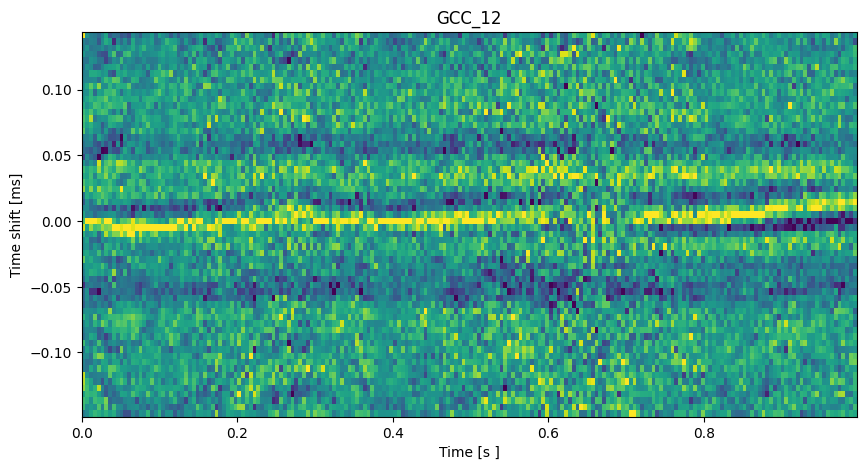

In [50]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.pcolormesh(time, time_shifts*1000, GCC_12.T, vmin = -1, vmax = 1)
ax.set_title('GCC_12')
ax.set_xlabel('Time [s ]')
ax.set_ylabel('Time shift [ms]')
ax.set_aspect('auto')


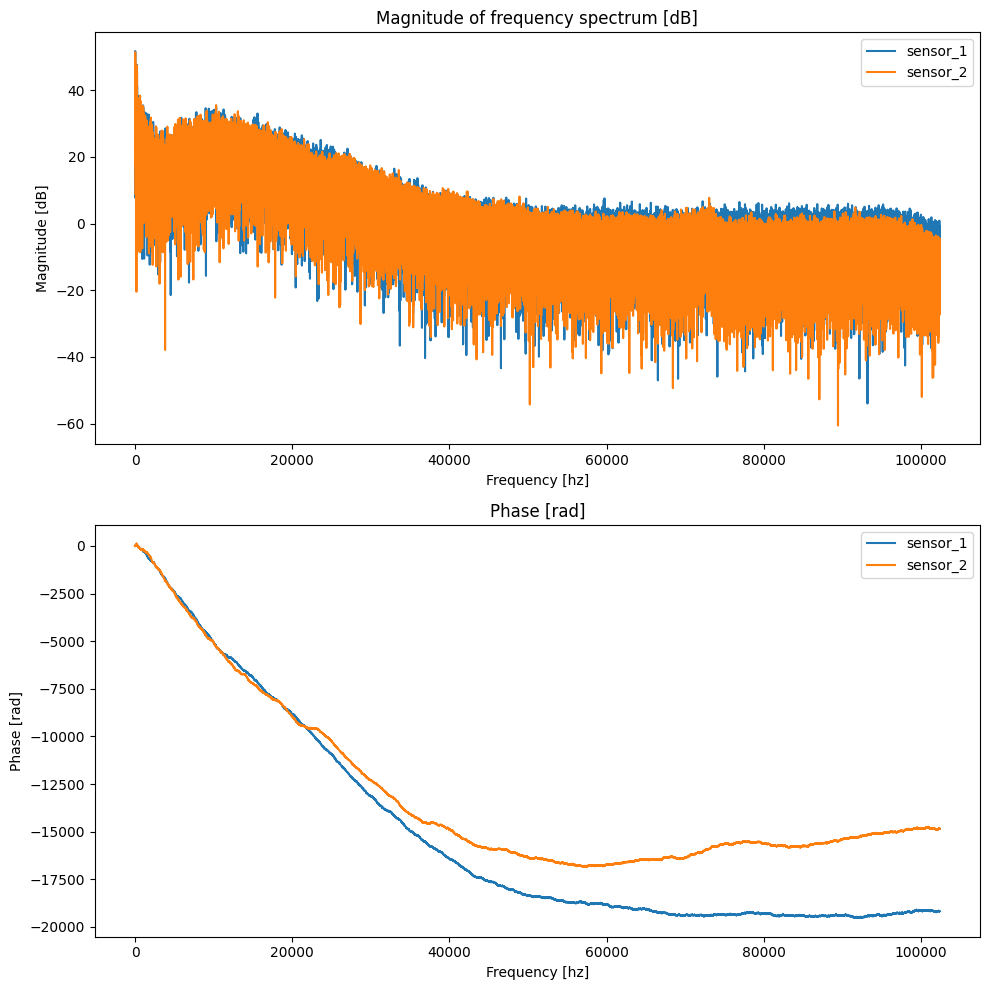

In [51]:
fft_sensor_1 = rfft(sensor_1)[1:]
fft_sensor_2 = rfft(sensor_2)[1:]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax = ax.ravel()

ax[0].plot(np.log10(np.abs(fft_sensor_1))*20, label = "sensor_1")
ax[0].plot(np.log10(np.abs(fft_sensor_2))*20, label = "sensor_2")
ax[0].set_title("Magnitude of frequency spectrum [dB]")
ax[0].set_xlabel("Frequency [hz]")
ax[0].set_ylabel("Magnitude [dB]")


ax[1].plot(np.unwrap(np.angle(fft_sensor_1)), label = "sensor_1")
ax[1].set_title("Phase [rad]")
ax[1].plot(np.unwrap(np.angle(fft_sensor_2)), label = "sensor_2")
ax[1].set_xlabel("Frequency [hz]")
ax[1].set_ylabel("Phase [rad]")


ax[0].legend()
ax[1].legend()

fig.tight_layout()



#### Calculating the cross correlation and auto correlation for the system noise

100%|██████████| 204/204 [00:00<00:00, 8828.56it/s]


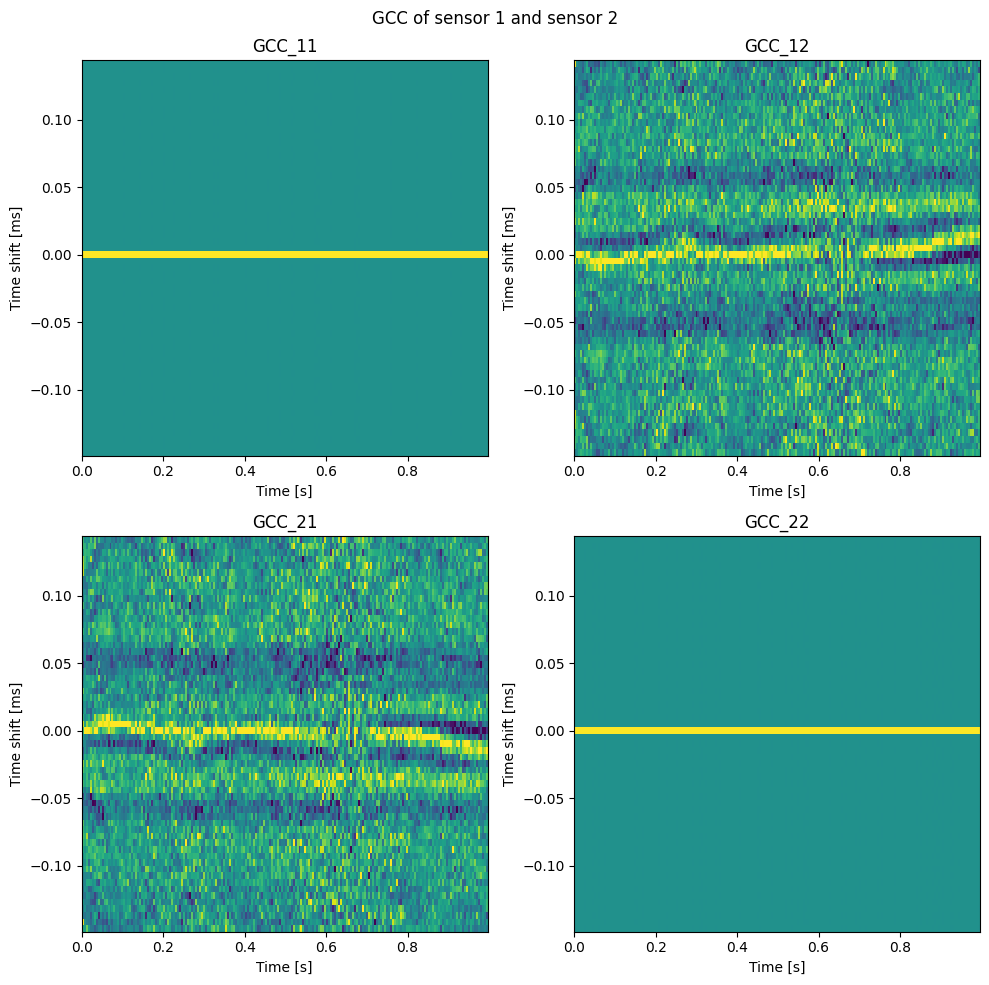

In [52]:
GCC_q1q1 = create_gcc(sensor_1, sensor_1, window_size, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q1q2 = create_gcc(sensor_1, sensor_2, window_size, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q1 = create_gcc(sensor_2, sensor_1, window_size, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q2 = create_gcc(sensor_2, sensor_2, window_size, step_size, truncate_length, window_type, beta, correlation_type)

fig, ax = plt.subplots(2,2 ,figsize = (10,10))

ax = ax.ravel()

ax[1].pcolormesh(time, time_shifts*1000, GCC_q1q2.T, vmin = -1, vmax = 1)
ax[1].set_title('GCC_12')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Time shift [ms]')
ax[1].set_aspect('auto')

ax[0].pcolormesh(time, time_shifts*1000, GCC_q1q1.T, vmin = -1, vmax = 1)
ax[0].set_title('GCC_11')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Time shift [ms]')
ax[0].set_aspect('auto')


ax[3].pcolormesh(time, time_shifts*1000, GCC_q2q2.T, vmin = -1, vmax = 1)
ax[3].set_title('GCC_22')
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Time shift [ms]')
ax[3].set_aspect('auto')

ax[2].pcolormesh(time, time_shifts*1000, GCC_q2q1.T, vmin = -1, vmax = 1)
ax[2].set_title('GCC_21')
ax[2].set_xlabel('Time [s]')    
ax[2].set_ylabel('Time shift [ms]')
ax[2].set_aspect('auto')

fig.suptitle('GCC of sensor 1 and sensor 2')
fig.tight_layout()






#### Calculating the cross correlation for the filtered system signal

In [53]:
sensor_1 = signal.lfilter(filter, 1.0, sensor_1)
sensor_2 = signal.lfilter(filter, 1.0, sensor_2)



GCC_q1q2 = create_gcc(sensor_1,sensor_2, window_size, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q1q1 = create_gcc(sensor_1,sensor_1, window_size, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q2 = create_gcc(sensor_2,sensor_2, window_size, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q1 = create_gcc(sensor_2,sensor_1, window_size, step_size, truncate_length, window_type, beta, correlation_type)


fig, ax = plt.subplots(2,2 ,figsize = (10,10))

ax = ax.ravel()

ax[1].pcolormesh(time, time_shifts*1000, GCC_q1q2.T, vmin = -1, vmax = 1)
ax[1].set_title('GCC_12')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Time shift [ms]')
ax[1].set_aspect('auto')

ax[0].pcolormesh(time, time_shifts*1000, GCC_q1q1.T, vmin = -1, vmax = 1)
ax[0].set_title('GCC_11')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Time shift [ms]')
ax[0].set_aspect('auto')


ax[3].pcolormesh(time, time_shifts*1000, GCC_q2q2.T, vmin = -1, vmax = 1)
ax[3].set_title('GCC_22')
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Time shift [ms]')
ax[3].set_aspect('auto')

ax[2].pcolormesh(time, time_shifts*1000, GCC_q2q1.T, vmin = -1, vmax = 1)
ax[2].set_title('GCC_21')
ax[2].set_xlabel('Time [s]')    
ax[2].set_ylabel('Time shift [ms]')
ax[2].set_aspect('auto')
fig.suptitle('GCC of filtered sensor 1 and sensor 2')
fig.tight_layout()



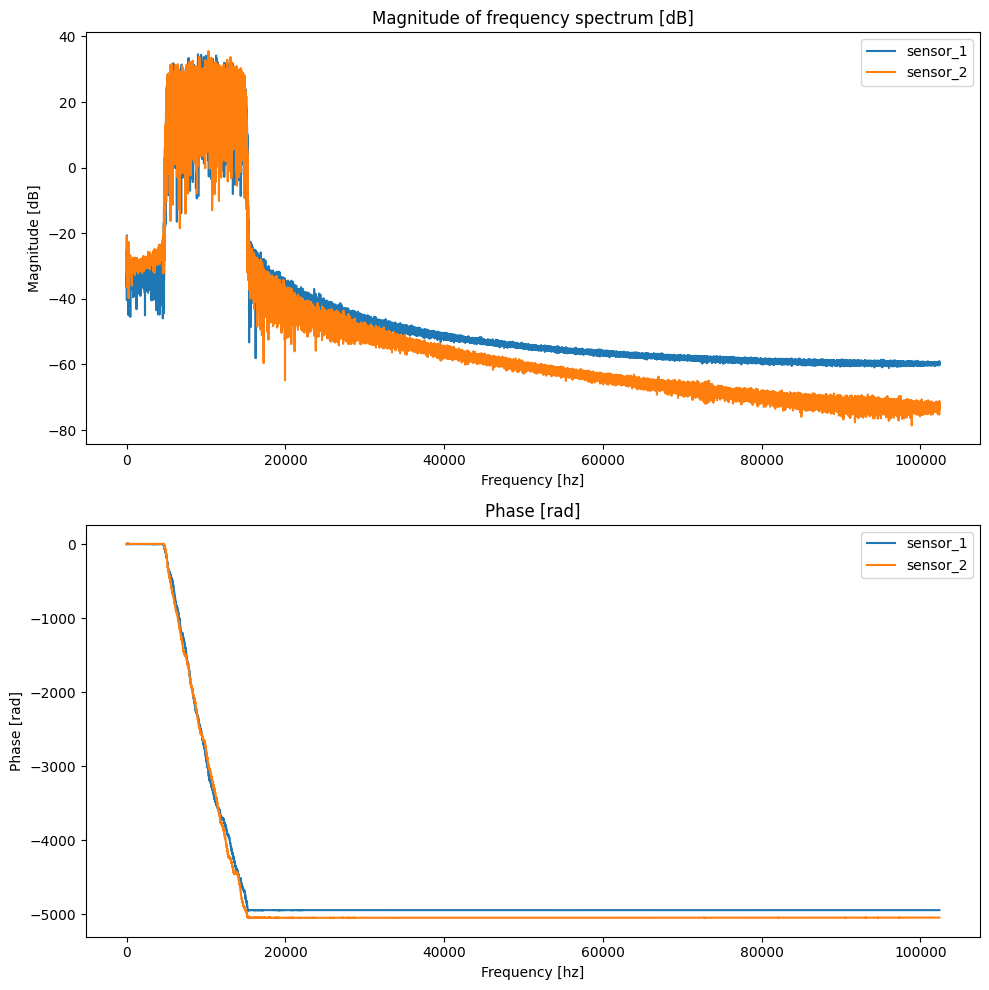

In [ ]:
fft_sensor_1 = rfft(sensor_1)[1:]
fft_sensor_2 = rfft(sensor_2)[1:]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax = ax.ravel()

ax[0].plot(np.log10(np.abs(fft_sensor_1))*20, label = "sensor_1")
ax[0].plot(np.log10(np.abs(fft_sensor_2))*20, label = "sensor_2")
ax[0].set_title("Magnitude of frequency spectrum [dB]")
ax[0].set_xlabel("Frequency [hz]")
ax[0].set_ylabel("Magnitude [dB]")


ax[1].plot(np.unwrap(np.angle(fft_sensor_1)), label = "sensor_1")
ax[1].set_title("Phase [rad]")
ax[1].plot(np.unwrap(np.angle(fft_sensor_2)), label = "sensor_2")
ax[1].set_xlabel("Frequency [hz]")
ax[1].set_ylabel("Phase [rad]")


ax[0].legend()
ax[1].legend()

fig.tight_layout()

